<a href="https://colab.research.google.com/github/bdgToji/VNP/blob/main/KOL2_Transformer_vs_NN_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Податочно множество
Симнете го датасетот од линкот кој ви е поставен на самата задача, потоа истиот поставете го локално за да го вчитате.
Во случај на грешка при вчитување на .csv додадете аргумент `encoding='latin-1`


In [1]:
!pip install -U accelerate
!pip install -U transformers[torch]
!pip install datasets
!pip install evaluate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, XLMForSequenceClassification
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/VNP/df_sentiment.csv', encoding='latin-1')

In [5]:
df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


#Претпроцесирање кое е потребно

In [6]:
df.isna().sum()

Text     0
Label    0
dtype: int64

In [7]:
df.describe()

,Label
count,2225.000000
mean,2.027416
std,1.438694
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [8]:
df = df.rename(columns={'Text':'text', 'Label':'label'})

In [9]:
df['label'].value_counts()

label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [11]:
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [12]:
dataset = load_dataset('csv', data_files={'train':'df_train.csv', 'test':'df_test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 445
    })
})

#Модел 1: Трансформер модел

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [24]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [25]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 445
    })
})

In [26]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
metric = evaluate.load("f1")

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [33]:
args = TrainingArguments(
    "sentiment",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
#model.to(device)

In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.227179
2,No log,0.158393
3,0.061800,0.132762


TrainOutput(global_step=669, training_loss=0.05060081453423151, metrics={'train_runtime': 576.3175, 'train_samples_per_second': 9.266, 'train_steps_per_second': 1.161, 'total_flos': 1405050880757760.0, 'train_loss': 0.05060081453423151, 'epoch': 3.0})

In [36]:
predictions = trainer.predict(tokenized_dataset['test'])

In [37]:
predictions

PredictionOutput(predictions=array([[-1.9919261 ,  9.425737  , -1.5358781 , -2.4566014 , -2.045883  ],
       [-1.9460489 ,  9.424279  , -1.5437901 , -2.44104   , -2.1175308 ],
       [-0.98689   , -1.9064772 , -2.077271  ,  7.502559  , -1.5825067 ],
       ...,
       [-1.8667024 , -2.9327404 ,  6.820333  , -2.8425252 , -0.01404957],
       [-1.8551278 , -2.942462  ,  6.642155  , -2.853227  ,  0.08818656],
       [-1.7948846 , -2.7711072 , -1.7839961 , -2.2931075 ,  7.954099  ]],
      dtype=float32), label_ids=array([1, 1, 3, 3, 4, 2, 3, 1, 2, 0, 4, 3, 4, 1, 3, 4, 3, 1, 1, 0, 3, 0,
       1, 1, 4, 0, 4, 4, 1, 3, 0, 4, 3, 4, 4, 4, 3, 1, 2, 4, 2, 1, 4, 2,
       4, 1, 2, 3, 3, 4, 2, 4, 4, 4, 3, 2, 1, 1, 2, 1, 4, 3, 4, 1, 1, 2,
       2, 2, 2, 4, 4, 4, 4, 2, 4, 3, 3, 0, 1, 0, 1, 1, 3, 3, 0, 0, 1, 4,
       2, 1, 2, 2, 2, 2, 2, 3, 2, 1, 4, 4, 4, 0, 2, 0, 1, 3, 3, 0, 3, 1,
       4, 0, 4, 4, 0, 0, 3, 1, 3, 3, 1, 2, 2, 3, 0, 4, 4, 1, 1, 1, 3, 2,
       4, 3, 1, 3, 4, 3, 4, 0, 4, 1, 2, 0, 0

In [81]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [82]:
preds

array([1, 1, 3, 3, 4, 2, 3, 1, 2, 0, 4, 3, 4, 1, 3, 4, 3, 1, 1, 0, 3, 0,
       1, 1, 4, 0, 2, 4, 1, 3, 0, 4, 3, 4, 0, 0, 3, 1, 2, 4, 2, 1, 4, 2,
       4, 1, 2, 3, 3, 4, 2, 4, 4, 4, 3, 2, 1, 1, 2, 1, 4, 3, 4, 1, 1, 2,
       2, 2, 2, 4, 4, 4, 4, 2, 4, 3, 3, 0, 1, 0, 4, 1, 3, 3, 0, 0, 1, 4,
       2, 1, 2, 2, 2, 2, 2, 3, 2, 1, 4, 4, 4, 0, 2, 0, 1, 3, 3, 0, 3, 1,
       4, 0, 4, 4, 0, 0, 3, 1, 3, 3, 1, 2, 2, 3, 0, 4, 4, 1, 1, 1, 3, 2,
       4, 3, 1, 3, 4, 3, 4, 0, 0, 1, 2, 0, 0, 4, 3, 1, 1, 0, 3, 4, 0, 3,
       4, 4, 0, 2, 2, 3, 1, 4, 4, 1, 0, 4, 3, 4, 4, 4, 2, 1, 1, 0, 2, 2,
       3, 1, 0, 1, 2, 1, 4, 1, 4, 4, 3, 3, 2, 1, 2, 4, 2, 4, 2, 0, 0, 0,
       0, 4, 3, 1, 4, 2, 1, 1, 3, 3, 3, 3, 0, 0, 2, 4, 4, 0, 3, 2, 2, 4,
       4, 4, 3, 1, 4, 0, 0, 4, 0, 0, 1, 1, 1, 3, 0, 3, 0, 2, 1, 2, 4, 2,
       4, 2, 1, 1, 4, 3, 4, 4, 4, 1, 2, 1, 3, 2, 1, 2, 4, 0, 1, 1, 2, 1,
       3, 1, 0, 0, 4, 4, 4, 2, 4, 1, 3, 0, 0, 1, 0, 4, 3, 1, 4, 4, 0, 4,
       0, 0, 4, 1, 1, 2, 3, 4, 2, 4, 4, 1, 2, 2, 1,

In [83]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        67
           1       1.00      0.99      1.00       101
           2       0.99      0.99      0.99        88
           3       0.99      1.00      0.99        73
           4       0.98      0.96      0.97       116

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



#Модел 2: Невронска мрежа

In [43]:
df

,text,label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0
...,...,...
2220,India opens skies to competition\n \n India wi...,4
2221,Yukos bankruptcy 'not US matter'\n \n Russian ...,4
2222,Survey confirms property slowdown\n \n Governm...,4
2223,High fuel prices hit BA's profits\n \n British...,4


<Axes: xlabel='label'>

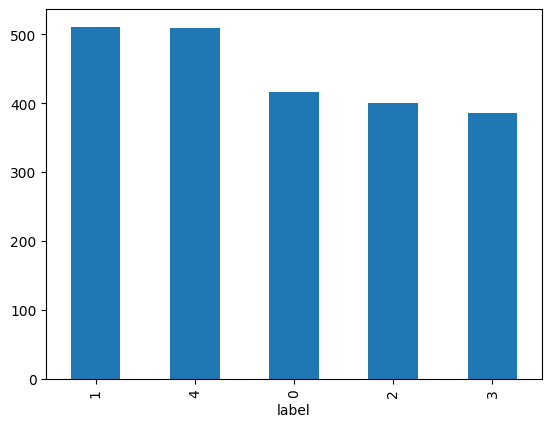

In [44]:
df['label'].value_counts().plot.bar()

In [46]:
df['text_length'] = df['text'].apply(len)

<Axes: >

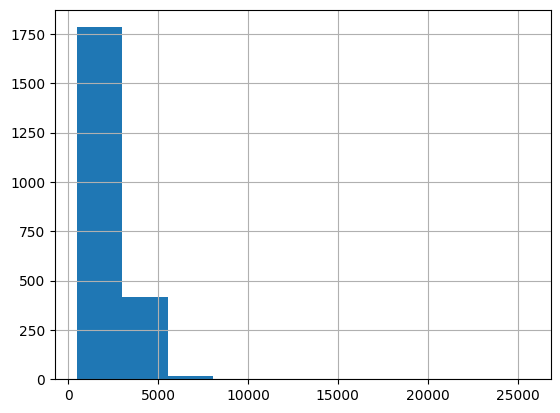

In [47]:
df['text_length'].hist()

In [50]:
X, Y = df['text'], pd.get_dummies(df['label'])

In [51]:
Y

,0,1,2,3,4
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
2220,False,False,False,False,True
2221,False,False,False,False,True
2222,False,False,False,False,True
2223,False,False,False,False,True


In [52]:
num_classes = len(Y.columns)

In [53]:
num_classes

5

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [55]:
df['num_words'] = df['text'].apply(lambda x: len(x.split(" ")))

<Axes: >

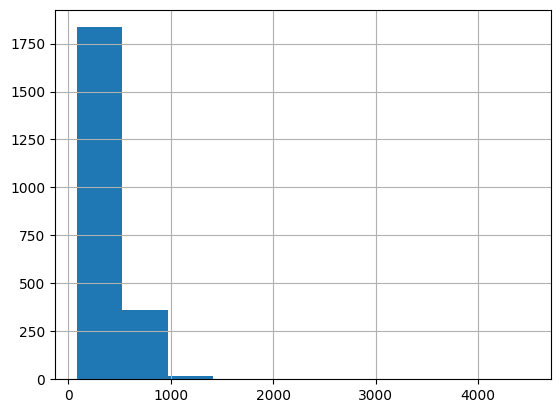

In [56]:
df['num_words'].hist()

In [57]:
max_tokens = 64

In [63]:
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train.values)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [64]:
len_tokens = [len(token_list) for token_list in X_train]

(array([1.07e+03, 6.20e+02, 7.50e+01, 6.00e+00, 4.00e+00, 0.00e+00,
        2.00e+00, 0.00e+00, 1.00e+00, 2.00e+00]),
 array([  17. ,  157.4,  297.8,  438.2,  578.6,  719. ,  859.4,  999.8,
        1140.2, 1280.6, 1421. ]),
 <BarContainer object of 10 artists>)

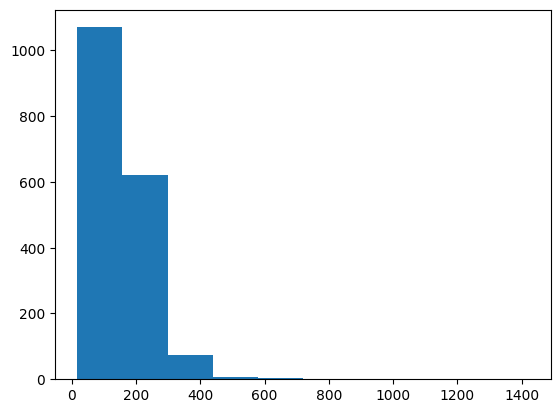

In [65]:
plt.hist(len_tokens)

In [66]:
maxlen=16

In [70]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [71]:
X_train.shape, X_test.shape

((1780, 16), (445, 16))

In [73]:
model = Sequential()
model.add(Embedding(max_tokens, 32, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

In [74]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [75]:
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=64, epochs=10)

Epoch 1/10
23/23 [==============================] - 14s 92ms/step - loss: 1.6062 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6034 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
23/23 [==============================] - 1s 50ms/step - loss: 1.5991 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
23/23 [==============================] - 1s 65ms/step - loss: 1.5838 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5703 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
23/23 [==============================] - 1s 35ms/step - loss: 1.4778 - precision: 0.6500 - recall: 0.0456 - val_loss: 1.5173 - val_precision: 0.4655 - val_recall: 0.0758
Epoch 5/10
23/23 [==============================] - 1s 29ms/step - loss: 1.3712 - precision: 0.7119 - recall: 0.1215 - val_loss: 1.4985 - val_precision: 0.5775 - val_recall: 0.1152
Epoch 6/10
23/23 [============================

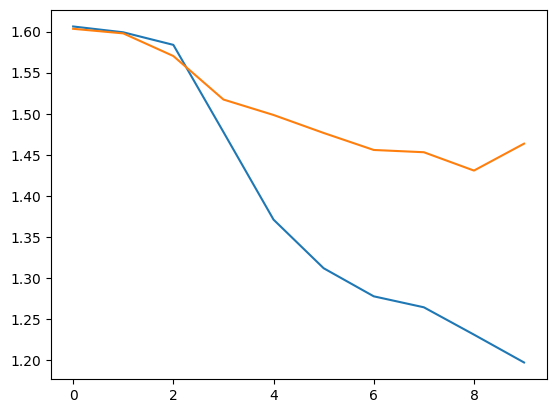

In [76]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

In [79]:
preds2 = model.predict(X_test)

14/14 [==============================] - 0s 9ms/step


#Eвалуација на двата модели и споредба

NN model

In [80]:
print(classification_report(np.argmax(Y_test.values, axis=1), np.argmax(preds2, axis=1)))

              precision    recall  f1-score   support

           0       0.40      0.65      0.50        92
           1       0.52      0.56      0.54        98
           2       0.49      0.30      0.37        77
           3       0.39      0.28      0.32        76
           4       0.54      0.47      0.50       102

    accuracy                           0.47       445
   macro avg       0.47      0.45      0.45       445
weighted avg       0.47      0.47      0.46       445



Transformer model

In [84]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        67
           1       1.00      0.99      1.00       101
           2       0.99      0.99      0.99        88
           3       0.99      1.00      0.99        73
           4       0.98      0.96      0.97       116

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



Transformer modelot e podobar od modelot so NN